In [1]:
from os import listdir
from os.path import isfile, join
# Import Packages and setup
import numpy as np
import scarlet
import scarlet.display
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping
from scarlet import Starlet

from scarlet_extensions.initialization.detection import makeCatalog, Data, mad_wavelet
import sep
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')
from astropy.nddata import Cutout2D
import warnings
warnings.simplefilter("ignore")

In [2]:
def makeCatalog(datas, lvl=3, wave=True):
    ''' Creates a detection catalog by combining low and high resolution data
    Parameters
    ----------
    datas: array
        array of Data objects
    lvl: int
        detection lvl
    wave: Bool
        set to True to use wavelet decomposition of images before combination
    Returns
    -------
    catalog: sextractor catalog
        catalog of detected sources
    bg_rms: array
        background level for each data set
    '''
    if type(datas) is np.ndarray:
        hr_images = datas / np.sum(datas, axis=(1, 2))[:, None, None]
        # Detection image as the sum over all images
        detect_image = np.sum(hr_images, axis=0)
    else:
        data_lr, data_hr = datas
        # Create observations for each image
        # Interpolate low resolution to high resolution
        interp = interpolate(data_lr, data_hr)
        # Normalisation of the interpolate low res images
        interp = interp / np.sum(interp, axis=(1, 2))[:, None, None]
        # Normalisation of the high res data
        hr_images = data_hr.images / np.sum(data_hr.images, axis=(1, 2))[:, None, None]
        # Detection image as the sum over all images
        detect_image = np.sum(interp, axis=0) + np.sum(hr_images, axis=0)
        detect_image *= np.sum(data_hr.images)
    if np.size(detect_image.shape) == 3:
        if wave:
            # Wavelet detection in the first three levels
            wave_detect = Starlet(detect_image.mean(axis=0), lvl=4).coefficients
            wave_detect[:, -1, :, :] = 0
            detect = scarlet.Starlet.from_image(coefficients=wave_detect).image
        else:
            # Direct detection
            detect = detect_image.mean(axis=0)
    else:
        if wave:
            wave_detect = scarlet.Starlet.from_image(detect_image).coefficients
            detect = wave_detect[0] + wave_detect[1] + wave_detect[2]
        else:
            detect = detect_image
    
    bkg = sep.Background(detect)
    catalog = sep.extract(detect, lvl, err=bkg.globalrms)

    if type(datas) is np.ndarray:
        bg_rms = mad_wavelet(datas)
    else:
        bg_rms = []
        for data in datas:
            bg_rms.append(mad_wavelet(data.images))

    return catalog, bg_rms

#Display function
def display_init(blend, obs, data, ids, img, title, save = False):
    # Load the model and calculate the residual
    model = blend.get_model()
    model = obs.render(model)
    
    init_rgb = scarlet.display.img_to_rgb(model, norm=hsc_norm)
    residual = data - model
    
    residual_rgb = scarlet.display.img_to_rgb(residual[:,:])
    vmax = np.max(np.abs(residual_rgb))
    if residual_rgb.shape[0]<2:
        residual_rgb = residual_rgb[0,:,:]
        
    plt.figure(ids,figsize=(20, 8))
    plt.suptitle(title, fontsize=36)
    plt.subplot(131)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Data", fontsize=20)
    plt.subplot(132)
    plt.imshow(init_rgb)
    plt.axis('off')
    plt.title("Model", fontsize=20)
    plt.subplot(133)
    plt.imshow(residual_rgb, vmin=-vmax, vmax=vmax, cmap = 'seismic')
    plt.axis('off')
    plt.title("Residuals", fontsize=20)
    if save is True:
        plt.savefig(title+'_'+str(coord[0])+'_'+str(coord[1])+'.png')
    pass

In [3]:
names = ['iras',
         'eso',
         'ngc',
         'tol',
         'sbs',
         'iras',
         'haro']

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


No handles with labels found to put in legend.


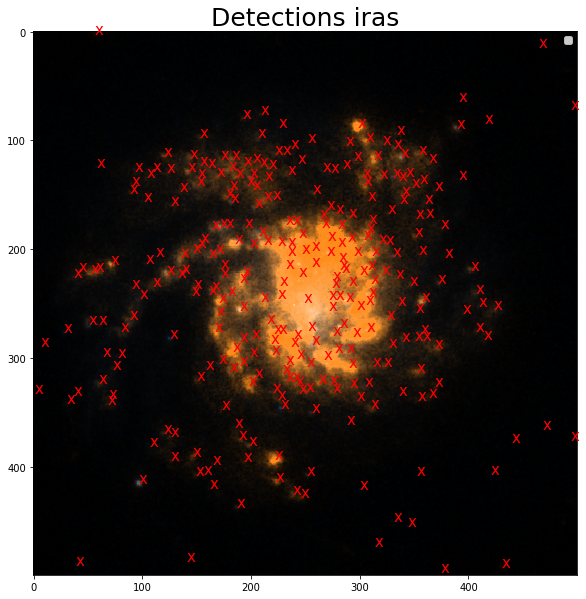

CPU times: user 7min 44s, sys: 21.1 s, total: 8min 5s
Wall time: 8min 5s
scarlet ran for 200 iterations to logL = -4292246.428555649


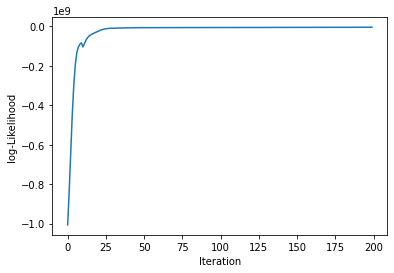

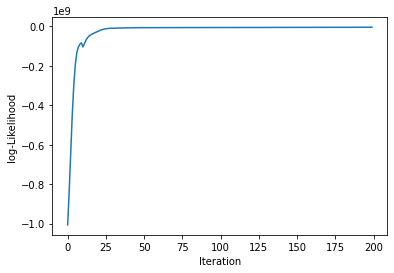

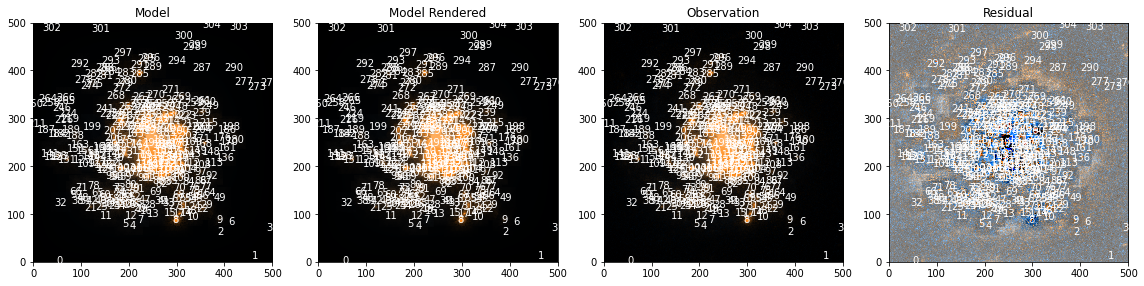

INFO: 
        Inconsistent SIP distortion information is present in the current WCS:
        SIP coefficients were detected, but CTYPE is missing "-SIP" suffix,
        therefore the current WCS is internally inconsistent.

        Because relax has been set to True, the resulting output WCS will have
        "-SIP" appended to CTYPE in order to make the header internally consistent.

        However, this may produce incorrect astrometry in the output WCS, if
        in fact the current WCS is already distortion-corrected.

        Therefore, if current WCS is already distortion-corrected (eg, drizzled)
        then SIP distortion components should not apply. In that case, for a WCS
        that is already distortion-corrected, please remove the SIP coefficients
        from the header.

         [astropy.wcs.wcs]


FileNotFoundError: [Errno 2] No such file or directory: 'Data/Cutouts/cut_iras_LSBG.fits'

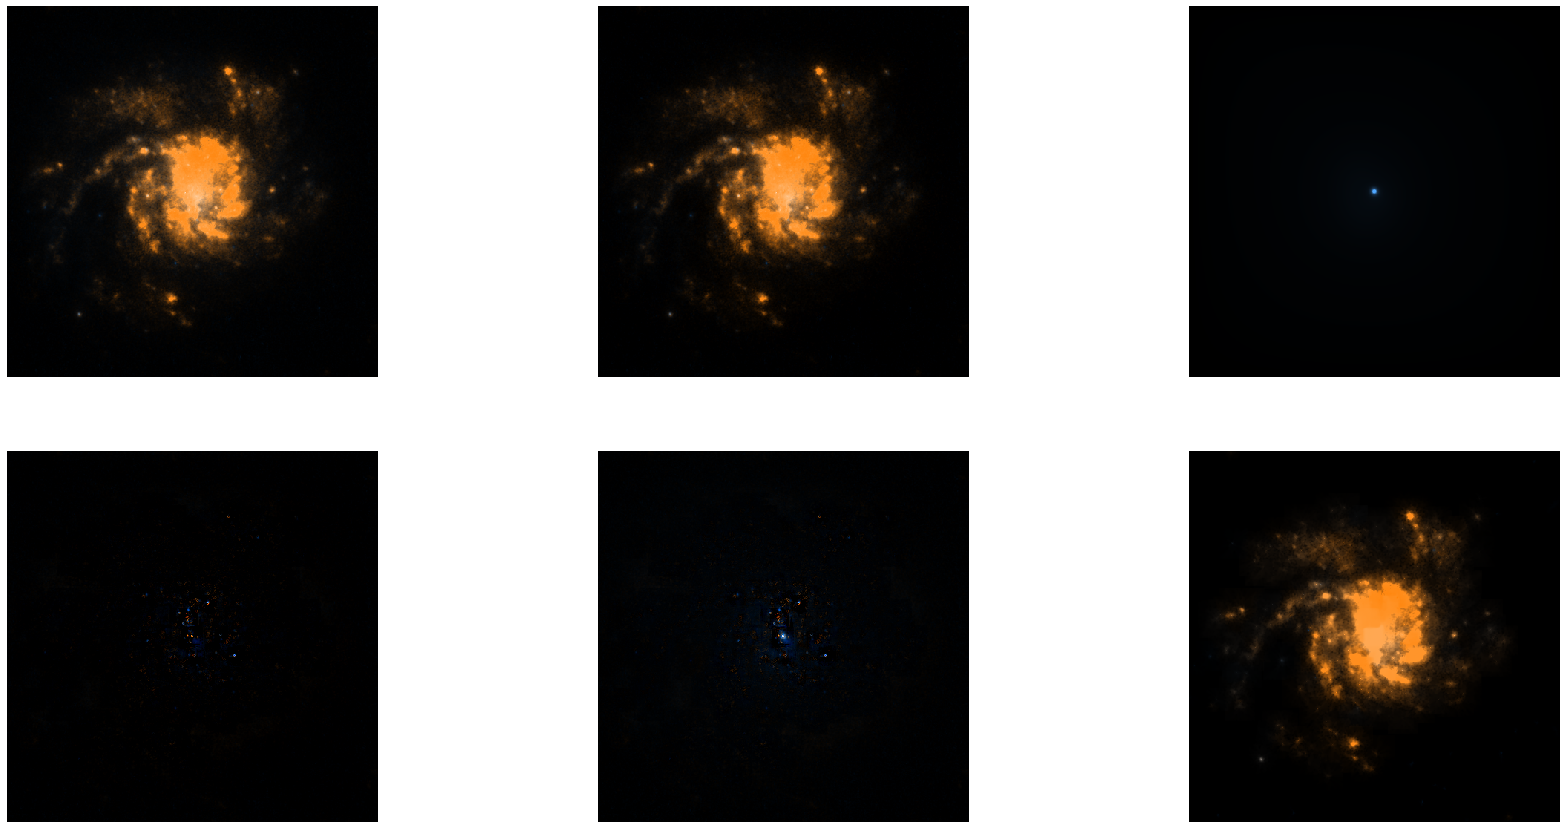

In [4]:
for n in names:
    cube = []
    hdu_lya = fits.open(f'Ostlin2009_lya/{n}_lyac.fits')
    cube.append(hdu_lya[0].data)
    
    hdu_ha = fits.open(f'Ostlin2009_ha/{n}_hac.fits')
    cube.append(hdu_ha[0].data)
    cube = np.array(cube)[::-1,500:1000,500:1000]*1.e19

    cube[np.isnan(cube)] = 0
    
    wcs = WCS(hdu_ha[0].header)
        
    cube = np.array(cube)
    psfs = scarlet.GaussianPSF( 0.5)
    channels = ['R','G']
    
    nc,nx,ny = np.shape(cube)
    
    data = {
        "images": cube, 
        "psfs":psfs,
        "wcs":wcs,
        "channels": channels}
    
    #Detection step. we identify all the source that we have to model.
    wave = True #True means wavelet detection. False is regular detection with sep. True is advised in this specific case
    
    lvl =3
    #Lower to get more faint sources. For source '6' and '7', lvl=4 is good, but for most other sources (25 for instance) you need to go down to 2 if you want to pick on the faint blended blobs
    catalog, bg_rms = makeCatalog(cube, lvl, wave)
    
    weights = np.ones_like(cube) / (bg_rms**2)[:, None, None]
    
    # Create a color mapping for the HSC image
    display_norm = AsinhMapping(minimum=-0.0001, stretch=10, Q=1.)
    
    # Get the source coordinates from the HST catalog
    pixel = np.stack((catalog['y'], catalog['x']), axis=1)
    
    # Convert the HST coordinates to the HSC WCS
    # Map the HSC image to RGB
    img_rgb = scarlet.display.img_to_rgb(cube, norm=display_norm)
    plt.figure(figsize=(10,10))

    plt.imshow(img_rgb)
    #plt.axis('off')
    
    for k,p in enumerate(pixel):
        plt.text(p[1], p[0], 'x', color="r", fontsize = 15)
    plt.legend()
    plt.title(f"Detections {n}", fontsize = 25)
    
    plt.show()
    
    # This is the residual PSF of the model as we don't fully deconvolve images. 
    model_psf = scarlet.GaussianPSF(sigma = 0.1)
    
    # The frame describes where the model lives
    model_frame = scarlet.Frame(
        cube.shape,
        psf=model_psf,
        channels=channels)
    
    # The observation describes where the data live and how to go from the model to the data.  
    observation = scarlet.Observation(
        cube, 
        psf= psfs, 
        weights=weights, 
        channels=channels).match(model_frame)
    
    starlet_sources = []
    for k,src in enumerate(catalog):
    
            new_source = scarlet.ExtendedSource(model_frame, 
                                            (src['y'], src['x']), 
                                            observation, 
                                            K=1, compact = True)
            starlet_sources.append(new_source)
    
    new_source = scarlet.StarletSource(model_frame, 
                            (nx/2, ny/2), [observation], 
                            thresh = 0.01,
                            starlet_thresh = 1,
                            boxsize = cube.shape[1],
                            spectrum = np.array([.9,0.1]))
                                       
    starlet_sources.append(new_source)  
    
    #new_source = scarlet.StarletSource(model_frame, 
    #                        (nx/2, ny/2), [observation], 
    #                        thresh = 0.01,
    #                        starlet_thresh = 1,
    #                        boxsize = cube.shape[1],
    #                        spectrum = np.array([0.,1.]))
    #starlet_sources.append(new_source)  
    
    starlet_blend = scarlet.Blend(starlet_sources, observation)
    
    %time it, logL = starlet_blend.fit(200, e_rel=1e-6)
    print(f"scarlet ran for {it} iterations to logL = {logL}")
    scarlet.display.show_likelihood(starlet_blend)
    plt.show()
    
    scarlet.display.show_likelihood(starlet_blend)
    plt.show()
    scarlet.display.show_scene(starlet_sources, 
                           norm=display_norm, 
                           observation=observation, 
                           show_rendered=True, 
                           show_observed=True, 
                           show_residual=True,
                          )
    plt.show()
    
    lsbg = starlet_sources[-1].get_model(frame=model_frame)
    contaminants = 0
    for s in starlet_sources[:-1]:
        contaminants += s.get_model(frame=model_frame)
    model = 0
    
    lsbg = observation.render(lsbg)
    contaminants = observation.render(contaminants)
    res_lsb = scarlet.display.img_to_rgb(cube-lsbg, norm=display_norm)
    res_rgb = scarlet.display.img_to_rgb(cube-lsbg-contaminants, norm=display_norm)
    img_rgb = scarlet.display.img_to_rgb(cube, norm=display_norm)
    lsbg_rgb = scarlet.display.img_to_rgb(lsbg, norm=display_norm)
    conta_rgb = scarlet.display.img_to_rgb(contaminants, norm=display_norm)
    res_c_rgb = scarlet.display.img_to_rgb(cube-contaminants, norm=display_norm)
    
    plt.figure(figsize = (30,15))
    plt.subplot(231)
    plt.imshow(img_rgb)
    #for k in range(len(catalog["x"])):
    #    plt.text(catalog["x"][k], catalog["y"][k], k, color = 'c', fontsize = 21)
    #plt.plot(catalog["x"], catalog["y"], 'co')
    plt.axis("off")
    
    plt.subplot(232)
    plt.imshow(res_lsb)
    plt.axis("off")
        
    plt.subplot(233)
    plt.imshow(lsbg_rgb)
    plt.axis("off")
    
    plt.subplot(234)
    plt.imshow(res_rgb)
    plt.axis("off")
        
    plt.subplot(235)
    plt.imshow(res_c_rgb)
    plt.axis("off")

    plt.subplot(236)
    plt.imshow(conta_rgb)
    plt.axis("off")
    